In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"koushalsanjaymodi","key":"08f98bce9fb8eb0c3626fc71db0aa6f7"}'}

In [3]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle competitions download -c dogs-vs-cats

 99% 802M/812M [00:04<00:00, 189MB/s]
100% 812M/812M [00:04<00:00, 207MB/s]


In [5]:
!unzip -qq dogs-vs-cats.zip

In [6]:
!unzip -qq train.zip

In [7]:
"""
cats_vs_dogs_small:
train: cats (1000) and dogs (1000)
val: cats (500) and dogs (500)
test: cats (1000) and dogs (1000)
"""

'\ncats_vs_dogs_small:\ntrain: cats (1000) and dogs (1000)\nval: cats (500) and dogs (500)\ntest: cats (1000) and dogs (1000)\n'

In [8]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

In [9]:
from tensorflow.keras import layers
from tensorflow import keras

In [10]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size = (180, 180),
    batch_size = 32
)

validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size = (180, 180),
    batch_size = 32
)

test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size = (180, 180),
    batch_size = 32
)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [11]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

In [12]:
import matplotlib.pyplot as plt

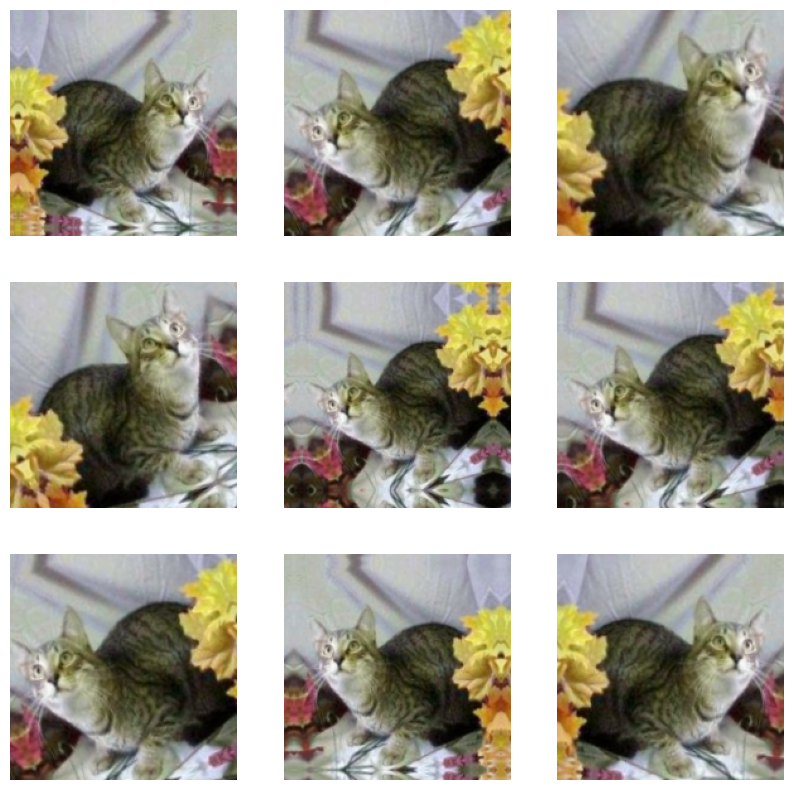

In [13]:
plt.figure(figsize = (10,10))
for images, _ in train_dataset.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3,3,i+1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [14]:
# without data augmentation: exact same 2000 images in every epoch which can cause overfitting
# with data augmentation: on different epochs/ batches, flipped version, rotated version, zoomed version

# dataset size is still 2000

inputs = keras.Input(shape = (180,180,3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters = 32, kernel_size=3, activation = "relu")(x)
x = layers.MaxPooling2D(pool_size = 2)(x)
x = layers.Conv2D(filters = 64, kernel_size = 3, activation = "relu")(x)
x = layers.MaxPooling2D(pool_size = 2)(x)
x = layers.Conv2D(filters = 128, kernel_size = 3, activation = "relu")(x)
x = layers.MaxPooling2D(pool_size = 2)(x)
x = layers.Conv2D(filters = 256, kernel_size=3, activation = "relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters = 256, kernel_size=3, activation = "relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation = "sigmoid")(x)
model = keras.Model(inputs = inputs, outputs = outputs)

model.compile(
    optimizer = "rmsprop",
    loss = "binary_crossentropy",
    metrics = ["accuracy"]
)

In [15]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath = "convnet_from_scratch_with_augmentation.keras",
        save_best_only = True,
        monitor = "val_loss"
    )
]

In [16]:
history = model.fit(
    train_dataset,
    epochs = 100,
    validation_data = validation_dataset,
    callbacks= callbacks
)

Epoch 1/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - accuracy: 0.5024 - loss: 0.7053 - val_accuracy: 0.5010 - val_loss: 0.6928
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.5042 - loss: 0.6933 - val_accuracy: 0.5000 - val_loss: 0.7567
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.5307 - loss: 0.6948 - val_accuracy: 0.5050 - val_loss: 0.6831
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.5656 - loss: 0.6868 - val_accuracy: 0.5670 - val_loss: 0.6905
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.5898 - loss: 0.6729 - val_accuracy: 0.5020 - val_loss: 1.3099
Epoch 6/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.6211 - loss: 0.7083 - val_accuracy: 0.6330 - val_loss: 0.6274
Epoch 7/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.6755 - loss: 0.6402 - val_accuracy: 0.6580 - val_loss: 0.6032
Epoch 8/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 86ms/step - accuracy: 0.6629 - loss: 0.6203 - val_accuracy: 0.

In [17]:
history_dict = history.history
history_dict.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

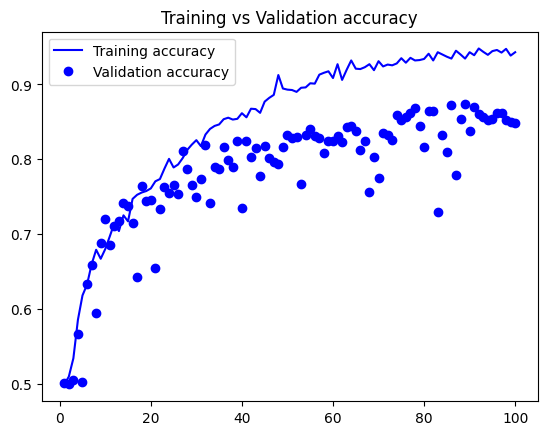

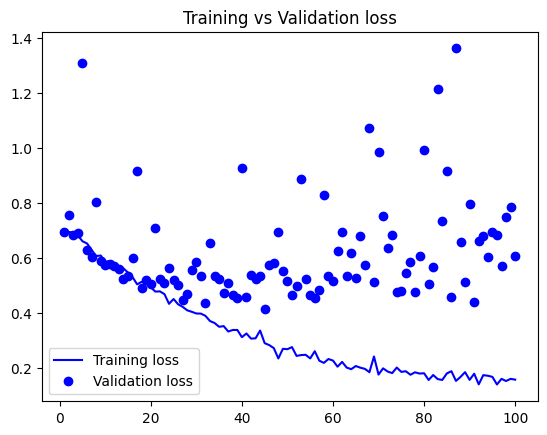

In [20]:
accuracy = history_dict["accuracy"]
val_accuracy = history_dict["val_accuracy"]
loss = history_dict["loss"]
val_loss = history_dict["val_loss"]
epochs = range(1, len(accuracy)+1)


plt.plot(epochs, accuracy, "b", label = "Training accuracy")
plt.plot(epochs, val_accuracy, "bo", label = "Validation accuracy")
plt.title("Training vs Validation accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss, "b", label = "Training loss")
plt.plot(epochs, val_loss, "bo", label = "Validation loss")
plt.title("Training vs Validation loss")
plt.legend()

plt.show()

In [25]:
import numpy as np

best_epoch_min_val_loss = np.argmin(val_loss) + 1
print(best_epoch_min_val_loss) # 45th epoch where validation loss is minimum

best_epoch_max_val_accuracy = np.argmax(val_accuracy) + 1
print(best_epoch_max_val_accuracy) # 89th epoch where validation accuracy is maximum

45
89


In [26]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation.keras")

test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.8472 - loss: 0.3972
Test accuracy: 0.828
